In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(False)

local
local


np.float64(0.35650769640692814)

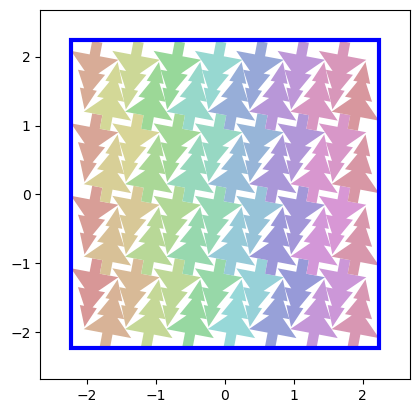

In [2]:
sol = kgs.dill_load(kgs.code_dir + '/../res/opt_practice.pickle')
sol.__class__ = kgs.SolutionCollectionSquare
assert isinstance(sol, kgs.SolutionCollection)
pack_vis_sol.pack_vis_sol(sol)
sol.h[0,0].get()**2/sol.N_trees

In [3]:
%%time
#%%pyinstrument
import lbfgs_torch_parallel
import importlib
import pack_ga
importlib.reload(lbfgs_torch_parallel)

sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1000)
sol_to_solve.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.01,sol_to_solve.xyt.shape))

sol_tmp = copy.deepcopy(sol_to_solve)
    
x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1)
from torch.utils.dlpack import to_dlpack, from_dlpack
import numpy as np
x0 = from_dlpack(x0.toDlpack())

counter = 0
counter_n = 0

cost = pack_ga.GA().fine_relaxers[0].cost

def f_torch(x):
    global counter, counter_n
    counter += 1
    counter_n += x.shape[0]
    x=cp.from_dlpack(to_dlpack(x))
    global sol_tmp
    NN = sol_tmp.N_trees*3
    sol_tmp.xyt = cp.ascontiguousarray(x[:,:NN].reshape(x.shape[0],-1,3))
    sol_tmp.h = cp.ascontiguousarray(x[:,NN:].reshape(x.shape[0],-1))
    tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)
    #tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)
    res = cp.zeros_like(x)
    res[:,:NN] = tmp_grad.reshape(sol_tmp.N_solutions,-1)
    res[:,NN:] = tmp_grad_h.reshape(sol_tmp.N_solutions,-1)
    #print(tmp_cost)
    return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())

kgs.debugging_mode = 2
f_torch(x0)

kgs.profiling=False
res=lbfgs_torch_parallel.lbfgs(
    f_torch,x0,tolerance_grad=1e-3, tolerance_change=0, max_iter=100, history_size=10, line_search_fn='strong_wolfe'
)
x_result = cp.from_dlpack(to_dlpack(res))
#print(x0[0].cpu().item(), x_result[0])

sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
val = cost.compute_cost_allocate(sol_opt)[0].get()
val_np = np.asarray(val)
if val_np.size == 1:
    print(counter, f"{val_np.item():.18e}")
else:
    print(counter, counter_n/counter, np.array2string(val_np, precision=18, floatmode='unique'), np.array2string(np.mean(val_np), precision=18, floatmode='unique'))

stop final relax at some point


<timed exec>:16: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
<timed exec>:38: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.


577 191.28249566724438 [0.19435308114392358 0.19435471901511717 0.19435307197783785
 0.19435329616646574 0.19435393500630793 0.19435312854595707
 0.194353254716448   0.19435375350313158 0.19435349584135367
 0.19435512121454548 0.19435354658390985 0.19435404296482164
 0.19435466160635786 0.19435421075030115 0.19436784882848154
 0.1943543397442227  0.1943715347624891  0.19435352042720636
 0.19435405074541748 0.19435374057925545 0.19435407379742417
 0.1943541815892357  0.19435346896315228 0.19435414381745522
 0.1943547001944597  0.1943534196738389  0.1943541727993557
 0.1943540102541316  0.19435348851577225 0.19435406252878115
 0.19436005832493533 0.19435353297698374 0.194353309627615
 0.19435347282139992 0.19435368995521046 0.1943539519562893
 0.19435380823719134 0.19435341186088834 0.19435359978392608
 0.19435384512789283 0.19435411433774843 0.19435380444055145
 0.19435431261258865 0.1943538926632476  0.19435442282540116
 0.19436392997632612 0.19435350902718973 0.1943538894092363
 0.194